In [26]:
import numpy as np 
import pandas as pd 
import os

# DATA visualization
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from IPython.display import Image, display
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import skimage 
# import openslide
import matplotlib

In [27]:
BASE_FOLDER = "/project/data/"   # if on gcloud 
# BASE_FOLDER = "../data/"  # if on local
!ls {BASE_FOLDER}


train = pd.read_csv(os.path.join(BASE_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(BASE_FOLDER, 'test.csv'))

image_dir = os.path.join(BASE_FOLDER, 
                         'train_images')
mask_dir = os.path.join(BASE_FOLDER,
                       'train_label_masks')

sample_submission.csv  test.csv   train_images
small_train.csv        train.csv  train_label_masks


In [28]:
print("unique ids: ", len(train))
print("unique data providers :" , len(train['data_provider'].unique()))
print("unique isup grade(target)", len(train['isup_grade'].unique()))
print("unique glean score", len(train['gleason_score'].unique()))

print("distinct values of gleason score", train['gleason_score'].unique())

unique ids:  10616
unique data providers : 2
unique isup grade(target) 6
unique glean score 11
distinct values of gleason score ['0+0' '4+4' '3+3' '4+3' 'negative' '4+5' '3+4' '5+4' '5+5' '5+3' '3+5']


In [29]:
print(train[train['isup_grade'] == 0]['data_provider'].unique())
print(train[train['isup_grade'] ==0]['gleason_score'].unique())

['karolinska' 'radboud']
['0+0' 'negative']


# Let's define mapping from gleason score to isup_grade

In [30]:
gleason_to_isup_grade = {"3+3":1,"0+0":0,"3+4":2,"4+3":3,"4+4":4,"negative": 0,"4+5": 5,"5+4":5,"5+5":5,"3+5":4,"5+3":4,"4+3":2}

In [31]:
train.groupby(['gleason_score','isup_grade']).size().sort_values(ascending=False)

gleason_score  isup_grade
3+3            1             2666
0+0            0             1925
3+4            2             1342
4+3            3             1242
4+4            4             1126
negative       0              967
4+5            5              849
5+4            5              248
5+5            5              127
3+5            4               80
5+3            4               43
4+3            2                1
dtype: int64

In [32]:
train.groupby(['data_provider','gleason_score']).size()

data_provider  gleason_score
karolinska     0+0              1925
               3+3              1814
               3+4               667
               3+5                13
               4+3               318
               4+4               466
               4+5               208
               5+3                 2
               5+4                27
               5+5                16
radboud        3+3               852
               3+4               675
               3+5                67
               4+3               925
               4+4               660
               4+5               641
               5+3                41
               5+4               221
               5+5               111
               negative          967
dtype: int64

# We should model this problem as predicting gleason score from biopsy sample and based on gleason score we determin the isup_grade.

Cleaning up the last row above, where "4+3" is mapped to two different isup_grade. The wrong one is isup_grade =2

In [33]:
print(train[train['gleason_score']=='4+3'].groupby(['isup_grade']).size())

query = (train['gleason_score'] == "4+3") & (train['isup_grade'] ==2)
print(train.index[query])

train.drop(train.index[query], inplace=True)


isup_grade
2       1
3    1242
dtype: int64
Int64Index([7273], dtype='int64')


# Radbound having glean_score of negative mapped to isup_grade. It should be converted to glean_score of "0+0"

In [34]:
train["gleason_score"] = train["gleason_score"].apply(lambda x : "0+0" if x=="negative" else x)

# Let's verify that we got 10 different gleason scores and all of them have unique gleason score.

In [35]:
train.groupby(['gleason_score','isup_grade']).size().sort_values(ascending=False)

gleason_score  isup_grade
0+0            0             2892
3+3            1             2666
3+4            2             1342
4+3            3             1242
4+4            4             1126
4+5            5              849
5+4            5              248
5+5            5              127
3+5            4               80
5+3            4               43
dtype: int64

# Let's create a small df which has 10 images of each gleason scores. (5 for each data provider)

In [36]:
g0_r = train[(train['gleason_score']=="0+0") & (train['data_provider'] == 'radboud')].sample(5).index
g0_k = train[(train['gleason_score']=="0+0") & (train['data_provider'] == 'karolinska')].sample(5).index

g1_r = train[(train['gleason_score']=="3+3") & (train['data_provider'] == 'radboud')].sample(5).index
g1_k = train[(train['gleason_score']=="3+3") & (train['data_provider'] == 'karolinska')].sample(5).index

g2_r = train[(train['gleason_score']=="3+4") & (train['data_provider'] == 'radboud')].sample(5).index
g2_k = train[(train['gleason_score']=="3+4") & (train['data_provider'] == 'karolinska')].sample(5).index

g3_r = train[(train['gleason_score']=="4+3") & (train['data_provider'] == 'radboud')].sample(5).index
g3_k = train[(train['gleason_score']=="4+3") & (train['data_provider'] == 'karolinska')].sample(5).index

# 15 for radboud isup 4 : 4+4, 3+5 , 5+3
g4_44_r = train[(train['gleason_score']=="4+4") & (train['data_provider'] == 'radboud')].sample(5).index
g4_35_r = train[(train['gleason_score']=="3+5") & (train['data_provider'] == 'radboud')].sample(5).index
g4_53_r = train[(train['gleason_score']=="5+3") & (train['data_provider'] == 'radboud')].sample(5).index

# 15 for karolinska isup 4 : 4+4, 3+5 , 5+3
g4_44_k = train[(train['gleason_score']=="4+4") & (train['data_provider'] == 'karolinska')].sample(5).index
g4_35_k = train[(train['gleason_score']=="3+5") & (train['data_provider'] == 'karolinska')].sample(5).index
g4_53_k = train[(train['gleason_score']=="5+3") & (train['data_provider'] == 'karolinska')].sample(2).index # we have we few samples here

# 15 for radboud isup 5 : 4+5, 5+4 , 5+5
g5_45_r = train[(train['gleason_score']=="4+5") & (train['data_provider'] == 'radboud')].sample(5).index
g5_54_r = train[(train['gleason_score']=="5+4") & (train['data_provider'] == 'radboud')].sample(5).index
g5_55_r = train[(train['gleason_score']=="5+5") & (train['data_provider'] == 'radboud')].sample(5).index

# 15 for karolinska isup 5 : 4+5, 5+4 , 5+5
g5_45_k = train[(train['gleason_score']=="4+5") & (train['data_provider'] == 'karolinska')].sample(5).index
g5_54_k = train[(train['gleason_score']=="5+4") & (train['data_provider'] == 'karolinska')].sample(5).index
g5_55_k = train[(train['gleason_score']=="5+5") & (train['data_provider'] == 'karolinska')].sample(5).index

indices_samples = g0_r | g0_k |  g1_r | g1_k | g2_r | g2_k | g3_r | g3_k | g4_44_r | g4_35_r | g4_53_r | g4_44_k | g4_35_k | g4_53_k | g5_45_r | g5_54_r | g5_55_r | g5_45_k  | g5_54_k | g5_55_k

print("Collected small samples" , len(indices_samples))

small_train = train.loc[indices_samples]

Collected small samples 97


In [37]:
small_train.head()

,image_id,data_provider,isup_grade,gleason_score
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3
164,044b0937a90ecc3347acac21e9cd39f6,radboud,5,5+4
184,04e1a953bceb9b1a0a5bf8840614aa04,karolinska,4,4+4
207,05819281002c55258bb3086cc55e3b48,karolinska,4,3+5
216,05a5622cb79be8e83a265ee80fd52d86,karolinska,4,4+4


In [38]:
# small_train.to_csv("../data/small_train.csv")
# !ls ../data/

small_train.to_csv(BASE_FOLDER+"small_train.csv")
# !ls BASE_FOLDER


In [40]:
from skimage import io

In [45]:
image = skimage.io.MultiImage(os.path.join(BASE_FOLDER+"train_images", '005e66f06bce9c2e49142536caf2f6ee.tiff'))[-1]
mask = skimage.io.MultiImage(os.path.join(BASE_FOLDER+"train_mask_images", '005e66f06bce9c2e49142536caf2f6ee_mask.tiff'))[-1]
# ??display

plt.imshow(image, interpolation='nearest')
plt.show()

plt.imshow(mask, interpolation='nearest')
plt.show()

IndexError: There are only 0 images in the collection

In [17]:
# Open the image (does not yet read the image into memory)
example = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", '005e66f06bce9c2e49142536caf2f6ee.tiff'))

# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
patch = example.read_region((17800,19500), 0, (256, 256))

# Display the image
display(patch)

# Close the opened slide after use
example.close()

NameError: name 'openslide' is not defined

In [13]:
small_train = small_train.set_index('image_id')
small_train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
02a2dcd6ad8bc1d9ad7fdc04ffb6dff3,radboud,5,5+4
0382081d894cac755a53ca7f241f014f,karolinska,2,3+4
051a2228aadbb0d44e61f8507114a4c0,radboud,4,5+3
095d32f7716c9ff9892a7696d2325ea1,radboud,1,3+3
0c74f7e82d446bd1cde9628fd6fa94e3,radboud,3,4+3


In [14]:
train = train.set_index('image_id')
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [15]:
def get_values(image_id,max_size=(600,400)):
#     print(os.path.join(BASE_FOLDER+"train_images", image +'.tiff'))
    slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", image_id +'.tiff'))
    
    print(slide.dimensions,slide.properties['tiff.XResolution'])
    
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    f,ax =  plt.subplots(2 ,figsize=(6,16))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    patch = slide.read_region((1780,1950), 0, (256, 256)) #ZOOMED FUGURE
    
    ax[0].imshow(patch) 
    ax[0].set_title('Zoomed Image')
    

    ax[1].imshow(slide.get_thumbnail(size=max_size)) #UNZOOMED FIGURE
    ax[1].set_title('Full Image')
    
    
    print("File id: {}".format(slide))
    print("Dimensions: {}".format(slide.dimensions))
    print("Microns per pixel / pixel spacing: {}".format(spacing))
    print("Number of levels in the image: {}".format(slide.level_count))
    print("Downsample factor per level: {}".format(slide.level_downsamples))
    print("Dimensions of levels: {}\n\n".format(slide.level_dimensions))
    
#     print("ISUP grade: {}".format(small_train.loc[image_id, 'isup_grade']))
#     print("Gleason score: {}".format(small_train.loc[image_id, 'gleason_score']))

(24900, 29228) 19872.883348294021
File id: OpenSlide('/project/data/train_images/07a7ef0ba3bb0d6564a73f4f3e1c2293.tiff')
Dimensions: (24900, 29228)
Microns per pixel / pixel spacing: 0.5031982437947761
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.00457121779945)
Dimensions of levels: ((24900, 29228), (6225, 7307), (1556, 1826))




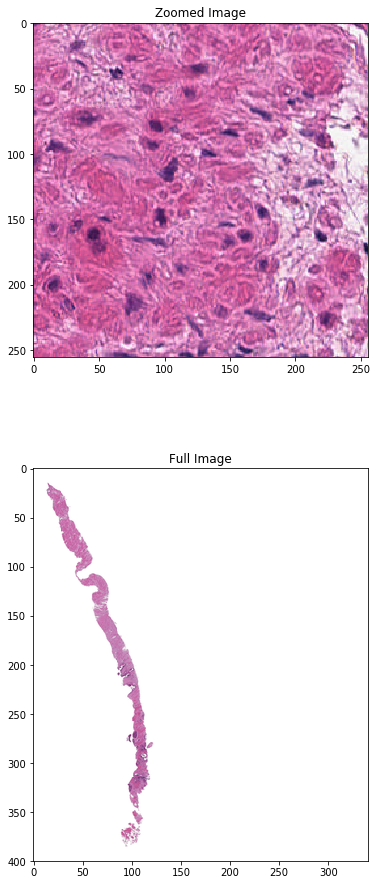

In [16]:
get_values('07a7ef0ba3bb0d6564a73f4f3e1c2293')

In [17]:
def display_images(images):
    '''
    This function takes in input a list of images. It then iterates through the image making openslide objects , on which different functions
    for getting out information can be called later
    '''
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", '{}.tiff'.format(image))) # Making Openslide Object
        #Here we compute the "pixel spacing": the physical size of a pixel in the image,
        #OpenSlide gives the resolution in centimeters so we convert this to microns
        spacing = 1/(float(slide.properties['tiff.XResolution']) / 10000)
        patch = slide.read_region((1780,1950), 0, (256, 256)) #Reading the image as before betweeen x=1780 to y=1950 and of pixel size =256*256
        ax[i//3, i%3].imshow(patch) #Displaying Image
        slide.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = image
#         data_provider = train.loc[image, 'data_provider']
#         isup_grade = train.loc[image, 'isup_grade']
#         gleason_score = train.loc[image, 'gleason_score']
#         ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 

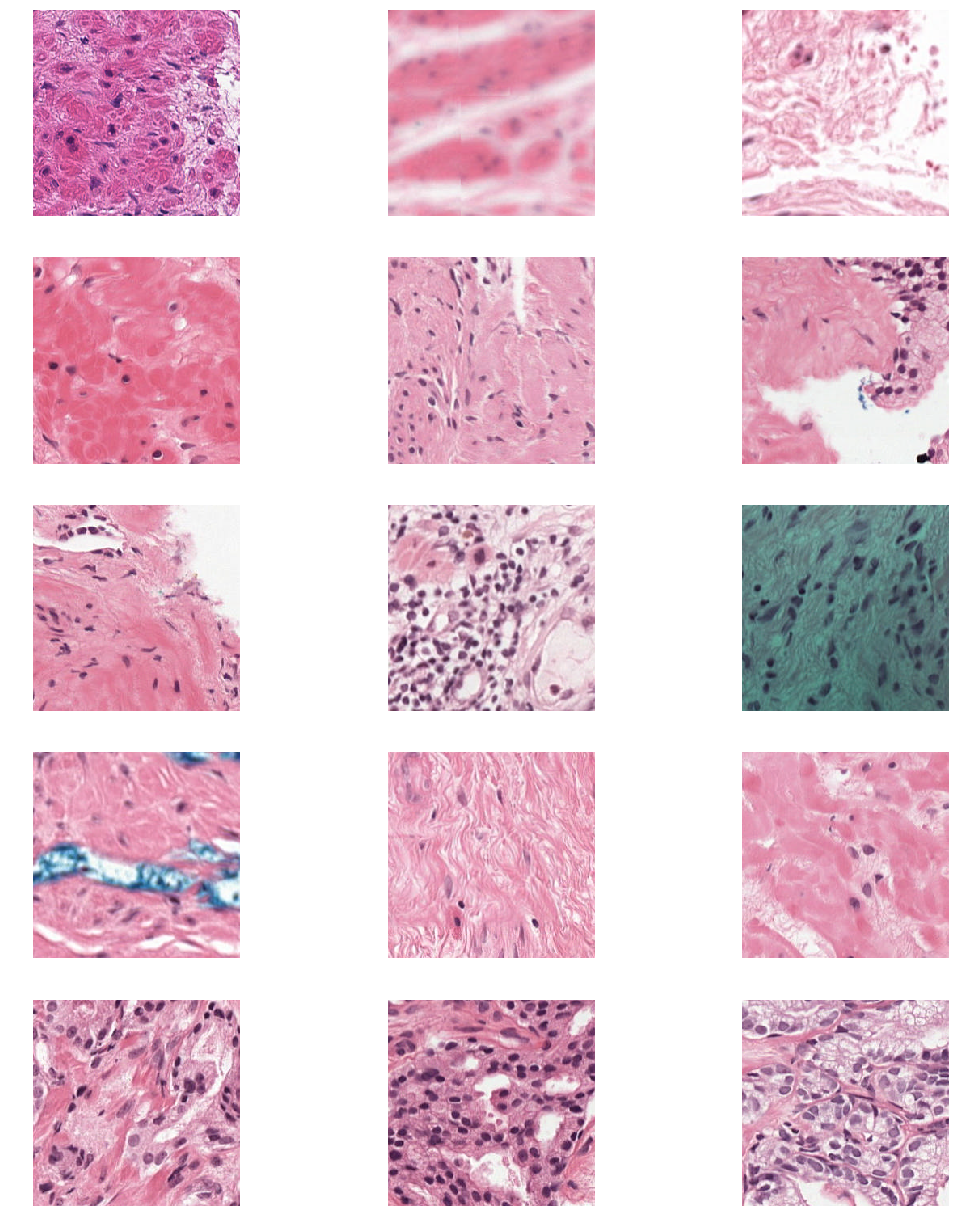

In [18]:
images= [ '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8']

display_images(images)

# Radboud Mask
     0: background (non tissue) or unknown
     1: stroma (connective tissue, non-epithelium tissue)
     2: healthy (benign) epithelium
     3: cancerous epithelium (Gleason 3)
     4: cancerous epithelium (Gleason 4)
     5: cancerous epithelium (Gleason 5)
 # Karolinska Mask
     1: background (non tissue) or unknown
     2: benign tissue (stroma and epithelium combined)
     3: cancerous tissue (stroma and epithelium combined)

In [19]:
def display_masks(slides):    
    f, ax = plt.subplots(2,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format(slide)))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
#         data_provider = train.loc[slide, 'data_provider']
#         isup_grade = train.loc[slide, 'isup_grade']
#         gleason_score = train.loc[slide, 'gleason_score']
#         ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()

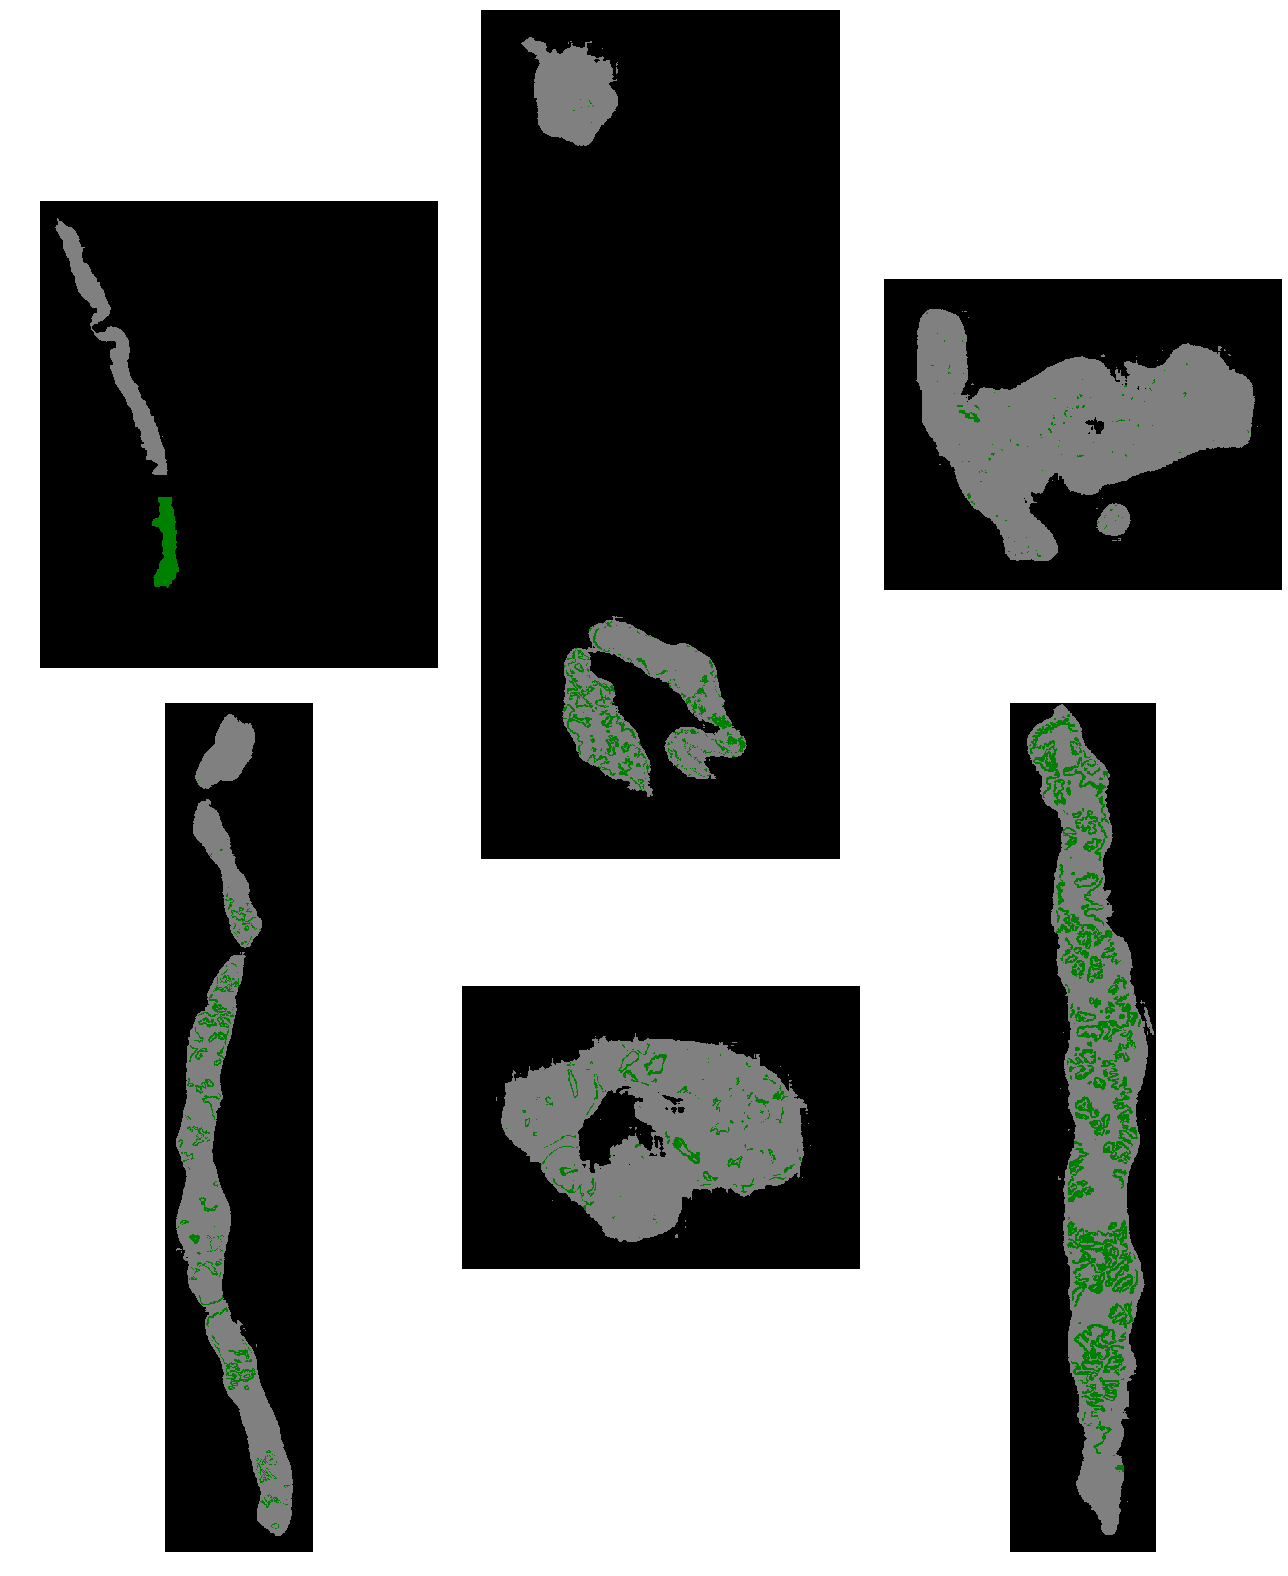

In [20]:
display_masks(images[:6]) 

In [21]:
def mask_img(image,max_size=(600,400)):
    slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", '{}.tiff'.format(image)))
    mask =  openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format(image)))
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    f,ax =  plt.subplots(1,2 ,figsize=(18,22))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    img = slide.get_thumbnail(size=(600,400)) #IMAGE 
    
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    
    ax[0].imshow(img) 
    #ax[0].set_title('Image')
    
    
    ax[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) #IMAGE MASKS
    #ax[1].set_title('Image_MASK')
    
    
    image_id = image
#     data_provider = train.loc[image, 'data_provider']
#     isup_grade = train.loc[image, 'isup_grade']
#     gleason_score = train.loc[image, 'gleason_score']
#     ax[0].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE")
#     ax[1].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE_MASK")

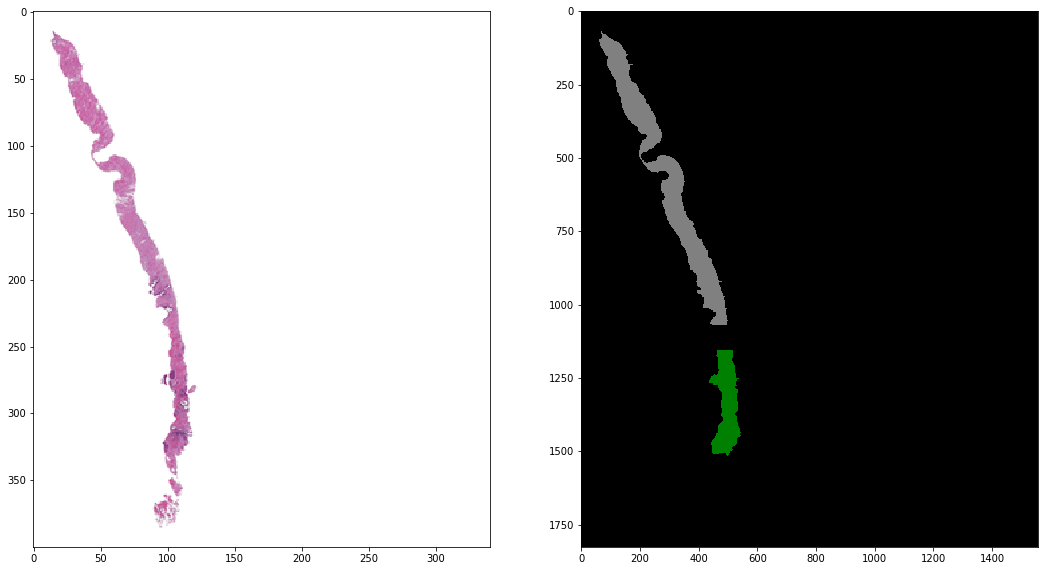

In [22]:
mask_img('07a7ef0ba3bb0d6564a73f4f3e1c2293')

In [23]:
def differentiate_cancerous(image_mask):
    mask =  openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format(image_mask)))
    mask_level = mask.read_region((0,0),mask.level_count - 1,mask.level_dimensions[-1]) #Selecting the level
    mask_data = np.asarray(mask_level)[:,:,0] #SELECTING R from RGB
    
    mask_background = np.where(mask_data == 0, 1, 0).astype(np.uint8) # SELECTING BG
    mask_benign = np.where(mask_data == 1, 1, 0).astype(np.uint8) #SELECTING BENIGN LABELS
    
    if train.loc[image_mask,'data_provider'] == 'karolinska':
        mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS
    elif train.loc[image_mask,'data_provider'] == 'radboud':
        mask_cancerous = np.where(mask_data == 5, 1, 0).astype(np.uint8) #SELECTING NON-CANCEROUS LABELS
        
    return mask_background,mask_benign,mask_cancerous

## Extracting image portion having cancer using mask

In [95]:
def extract_cancerous_portion(image_id):
    
    
    print("processing image id {}".format(image_id))
    
    mask = openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format(image_id)))
    mask_level = mask.read_region((0,0), mask.level_count-1, mask.level_dimensions[-1])

    mask_data = np.asarray(mask_level)[:,:,0]
    mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8)

    image = openslide.OpenSlide(os.path.join(image_dir, '{}.tiff'.format(image_id)))
    image_level = image.read_region((0,0), image.level_count-1, image.level_dimensions[-1])
    image_data = np.asarray(image_level)
    
    if train.loc[image_id,'data_provider'] == 'karolinska':
        indices_with_cancer = np.where(mask_data == 2)                  #SELECTING CANCEROUS LABELS INDICES
    elif train.loc[image_id,'data_provider'] == 'radboud':
        indices_with_cancer = np.where(mask_data == 3)                  #SELECTING CANCEROUS LABELS INDICES
        
    H, W = indices_with_cancer
    
    mask.close()
    image.close()
    
    print(H,W)
    return image_data, mask_data, image_data[min(H):max(H), min(W): max(W),:]




processing image id 095d32f7716c9ff9892a7696d2325ea1
[ 107  108  108 ... 1542 1543 1544] [259 258 259 ... 105 105 104]
3+3 radboud 1


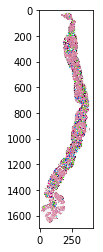

In [104]:
# cancer_portion_array
# print(cancer_portion_array.shape)
# plt.imshow(cancer_portion_array)
# plt.show()
image_array, mask_array, cancer_portion_array = extract_cancerous_portion("095d32f7716c9ff9892a7696d2325ea1")
print(small_train.loc["095d32f7716c9ff9892a7696d2325ea1"]["gleason_score"] + " " + small_train.loc["095d32f7716c9ff9892a7696d2325ea1"]["data_provider"],
     small_train.loc["095d32f7716c9ff9892a7696d2325ea1"]["isup_grade"] )
y=np.expand_dims(mask_array,axis=2)
newmask=np.concatenate((y,y,y,y),axis=2)
    
overlayed_array = image_array * newmask   


plt.imshow(overlayed_array)
plt.show()



processing image id 02a2dcd6ad8bc1d9ad7fdc04ffb6dff3
processing image id 0382081d894cac755a53ca7f241f014f
processing image id 051a2228aadbb0d44e61f8507114a4c0
processing image id 095d32f7716c9ff9892a7696d2325ea1


ValueError: min() arg is an empty sequence

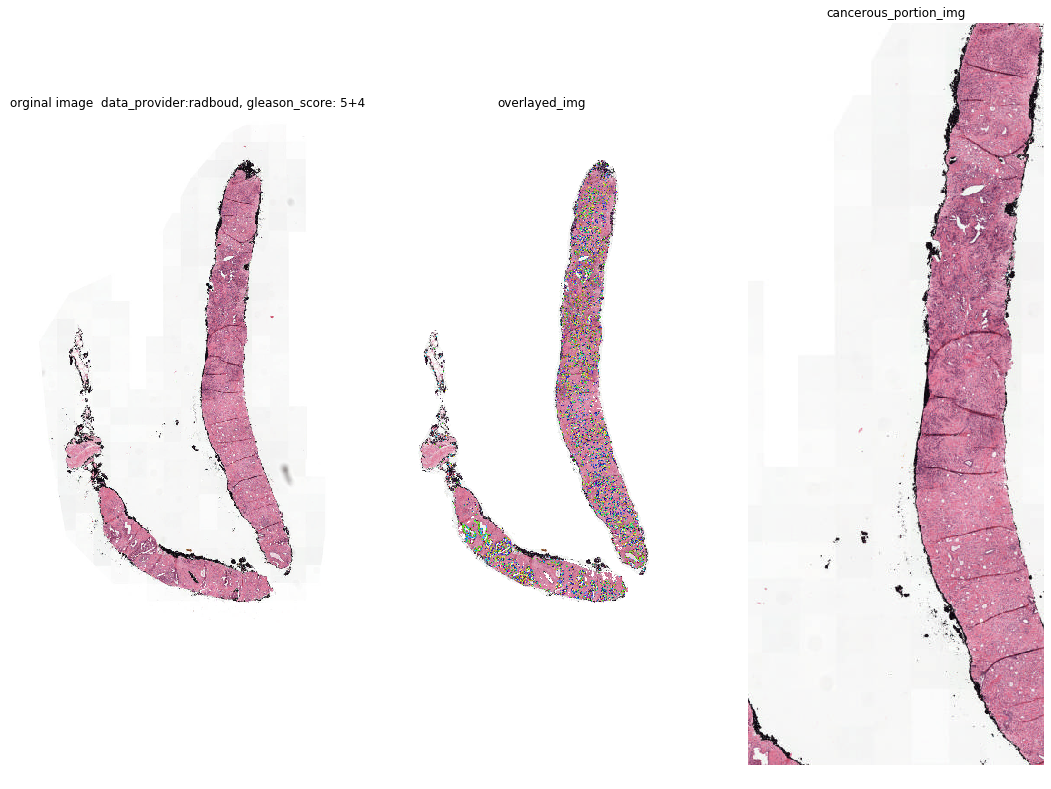

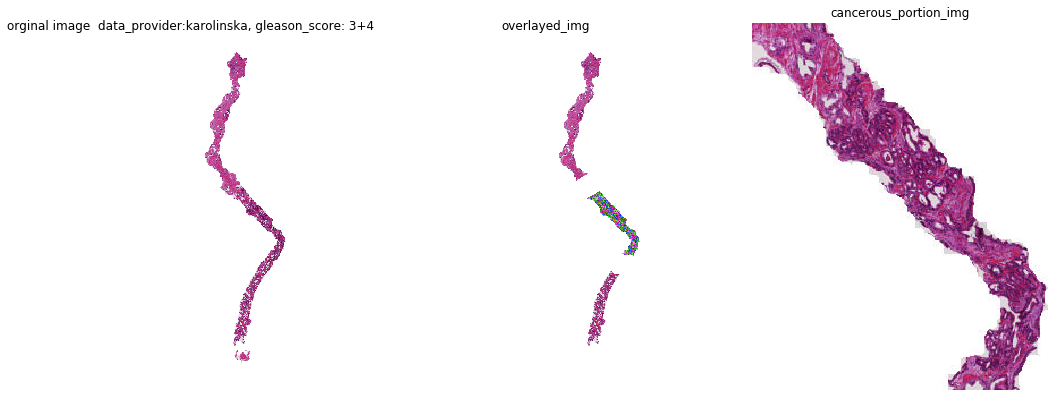

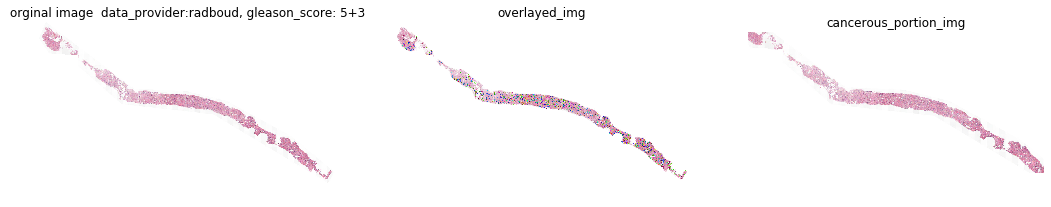

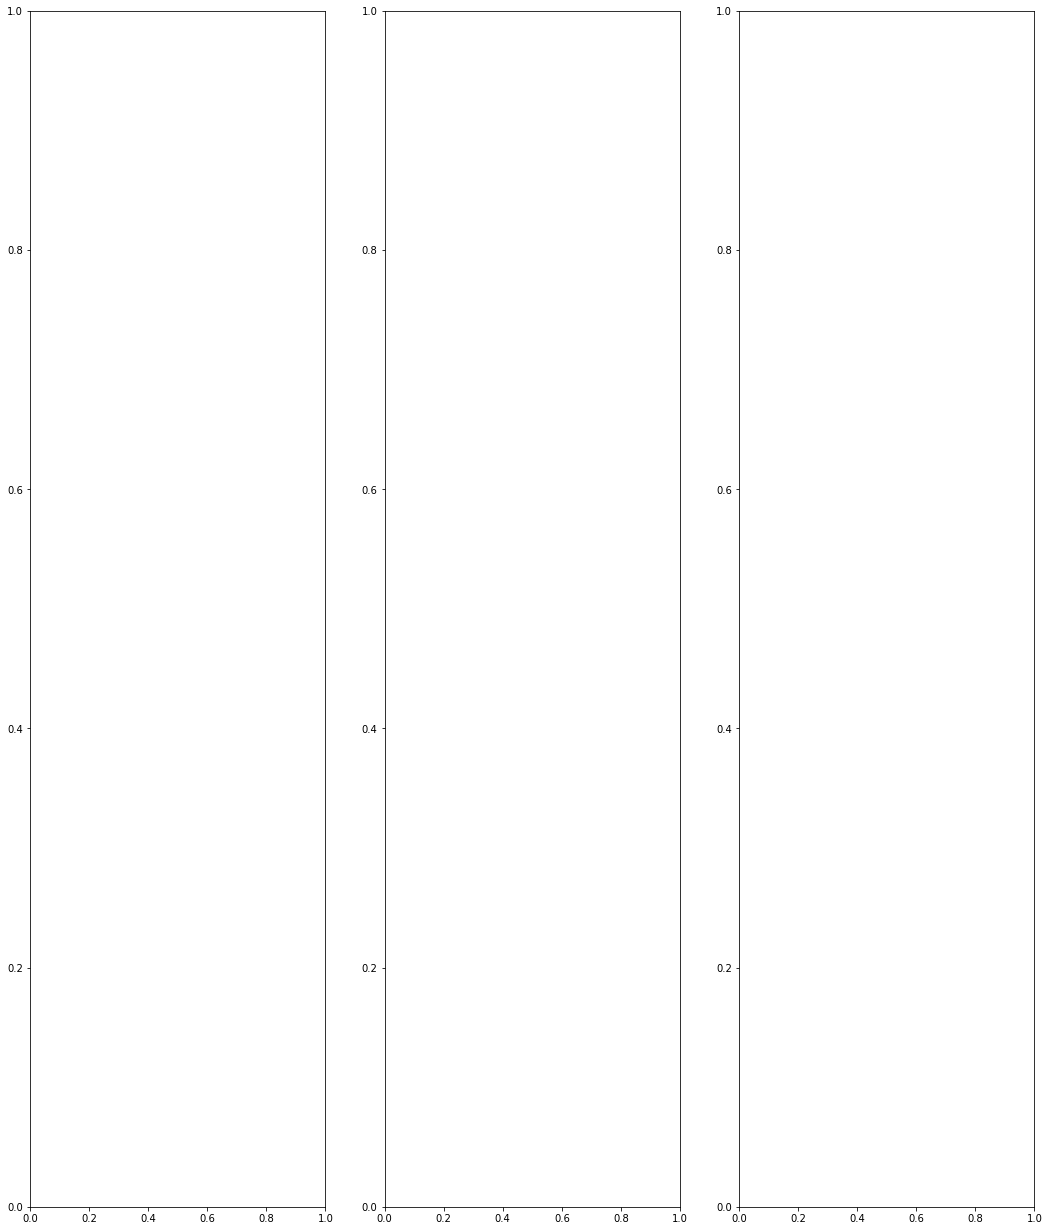

In [78]:
for i, image_id in enumerate(small_train.index): 
    
    fig, ax = plt.subplots(1, 3, figsize=(18,22))
    image_array, mask_array, cancerous_portion_array = extract_cancerous_portion(image_id)
    
    
    
    y=np.expand_dims(mask_array,axis=2)
    newmask=np.concatenate((y,y,y,y),axis=2)
    
    overlayed_array = image_array * newmask    
    
    ax[0].imshow(image_array)
    ax[0].axis('off')
    ax[0].set_title("orginal image " + ' data_provider:' + small_train.loc[image_id]["data_provider"] +
                   ", gleason_score: " + small_train.loc[image_id]["gleason_score"]);
    ax[1].imshow(overlayed_array)
    ax[1].axis('off')
    ax[1].set_title('overlayed_img');
    ax[2].imshow(cancerous_portion_array)
    ax[2].axis('off')
    ax[2].set_title("cancerous_portion_img")    
    
    if i == 6:
        break
            

In [25]:
mask = openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format('07a7ef0ba3bb0d6564a73f4f3e1c2293')))
mask_level = mask.read_region((0,0), mask.level_count-1, mask.level_dimensions[-1])

mask_data = np.asarray(mask_level)[:,:,0]
mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8)
print(mask_cancerous.shape)



image = openslide.OpenSlide(os.path.join(image_dir, '{}.tiff'.format('07a7ef0ba3bb0d6564a73f4f3e1c2293')))
image_level = image.read_region((0,0), image.level_count-1, image.level_dimensions[-1])
image_data = np.asarray(image_level)
print(image_data.shape)


print( mask.level_count)

(1826, 1556)
(1826, 1556, 4)
3


Tuple of arrays returned :  (array([1156, 1156, 1156, ..., 1513, 1514, 1514]), array([463, 464, 465, ..., 499, 498, 499]))
Image data height from : 1156 to 1514 and width from : 436 to 543


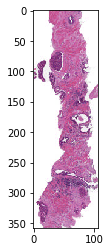

In [26]:
result = np.where(mask_data == 2)
print('Tuple of arrays returned : ', result)
H, W = result
print("Image data height from : {} to {} and width from : {} to {}".format(min(H) ,max(H),min(W) ,max(W)))

plt.imshow(image_data[1156:1514,436:543,:])
plt.show()

In [27]:
image_data[1156:1514,436:543,:].shape

(358, 107, 4)

## Aternative way to extract only pixels of an image where there is mask value

https://stackoverflow.com/questions/59160337/how-to-extract-only-the-pixels-of-an-image-where-it-is-masked-python-numpy-arr


(1826, 1556, 4)


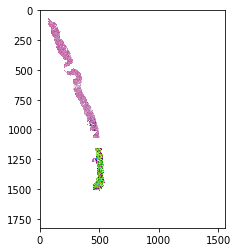

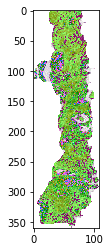

In [35]:
y=np.expand_dims(mask_data,axis=2)
newmask=np.concatenate((y,y,y,y),axis=2)

cob= image_data * newmask
print(cob.shape)
plt.imshow(cob)
plt.show()
plt.imshow(cob[1155:1515,435:544,:])
plt.show()

In [29]:
image2 =[ '07a7ef0ba3bb0d6564a73f4f3e1c2293','ffdc59cd580a1468eac0e6a32dd1ff2d']

(1826, 1556)
4+4


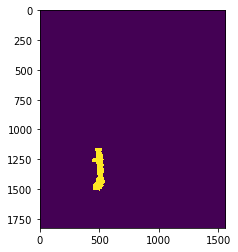

(320, 896)
4+5


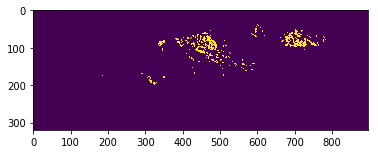

In [30]:
def getCancerousImage(image_id):
    
    """ Takes image id and returns the cancerous portion of image read from mask
    """
    
    mask = openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format(image_id)))
    mask_level = mask.read_region((0,0), mask.level_count-1, mask.level_dimensions[-1])
    
    mask_data = np.asarray(mask_level)[:,:,0] # Select R from R, G, B 
    
    mask_background = np.where(mask_data == 0,1,0).astype(np.uint8) # whereever we have mask value 0, convert to 1
    mask_benign = np.where(mask_data == 1,1,0).astype(np.uint8)
    
    if train.loc[image_id,'data_provider'] == 'karolinska':
        mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS
    elif train.loc[image_id,'data_provider'] == 'radboud':
        mask_cancerous = np.where(mask_data == 5, 1, 0).astype(np.uint8) #SELECTING NON-CANCEROUS LABELS
    
    mask.close()
    
    
    return mask_background,mask_benign,mask_cancerous,train.loc[image_id,'gleason_score'] 

for image in image2:
    _,non_cancerous_img,cancerous_img,gleason_score = getCancerousImage(image)
    print(cancerous_img.shape)
    print(gleason_score)
    plt.imshow(cancerous_img)
    plt.show()

In [31]:
# from skimage.measure import label, regionprops
# import cv2
# import skimage.io 
# import tifffile
# for image_id in image2:
    
    
# #     img = skimage.io.MultiImage(os.path.join(image_dir,image_id+'.tiff'))
#     image = imread(os.path.join(image_dir,image_id+'.tiff', key=2))
    
    
        

    


    """
for i in range(10):
    image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()    
   """

'\n        for i in range(10):\n            image = images_with_ship[i]\n\n            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))\n            img_0 = cv2.imread(train_image_dir+\'/\' + image)\n            rle_0 = masks.query(\'ImageId=="\'+image+\'"\')[\'EncodedPixels\']\n            mask_0 = masks_as_image(rle_0)\n            #\n            # \n            lbl_0 = label(mask_0) \n            props = regionprops(lbl_0)\n            img_1 = img_0.copy()\n            print (\'Image\', image)\n            for prop in props:\n                print(\'Found bbox\', prop.bbox)\n                cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)\n\n\n            ax1.imshow(img_0)\n            ax1.set_title(\'Image\')\n            ax2.set_title(\'Mask\')\n            ax3.set_title(\'Image with derived bounding box\')\n            ax2.imshow(mask_0[...,0], cmap=\'gray\')\n            ax3.imshow(img_1)\n            plt.show()    \n  

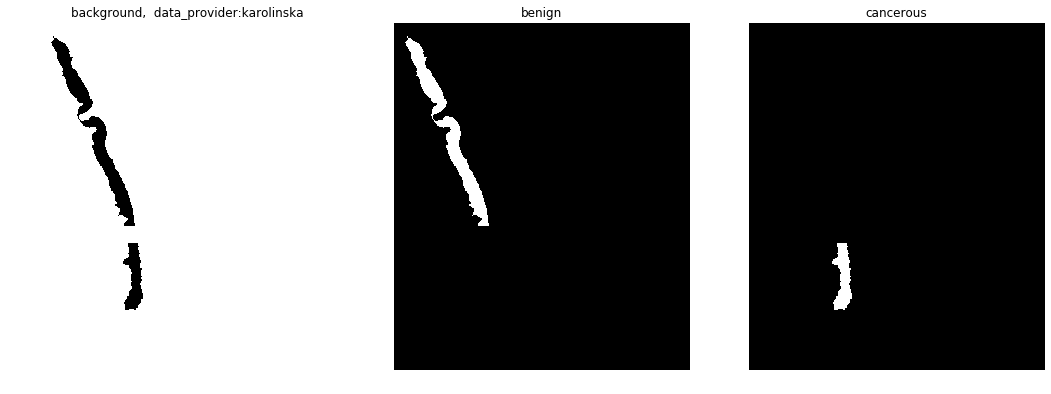

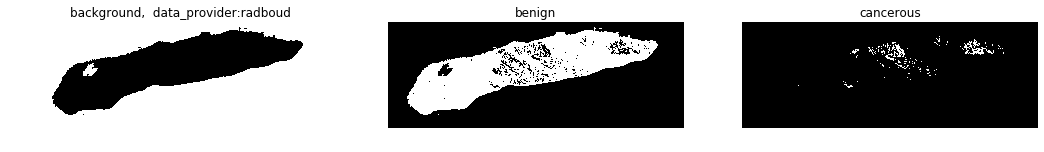

In [32]:


for image in image2:
    background,benign,cancerous = differentiate_cancerous(image)

    #if train.loc[image,'data_provider'] == 'karolinska'
    fig, ax = plt.subplots(1, 3, figsize=(18, 12))

    ax[0].imshow(background.astype(float), cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('background,'+'  '+'data_provider:'+train.loc[image]["data_provider"]);
    ax[1].imshow(benign.astype(float), cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('benign');
    ax[2].imshow(cancerous.astype(float), cmap=plt.cm.gray)
    ax[2].axis('off')
    ax[2].set_title('cancerous')

In [33]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(2,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", '{}.tiff'.format(image_id)))
        mask = openslide.OpenSlide(os.path.join(mask_dir, '{}_mask.tiff'.format(image_id)))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[image_id, 'data_provider']
        isup_grade = train.loc[image_id, 'isup_grade']
        gleason_score = train.loc[image_id, 'gleason_score']
#         ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

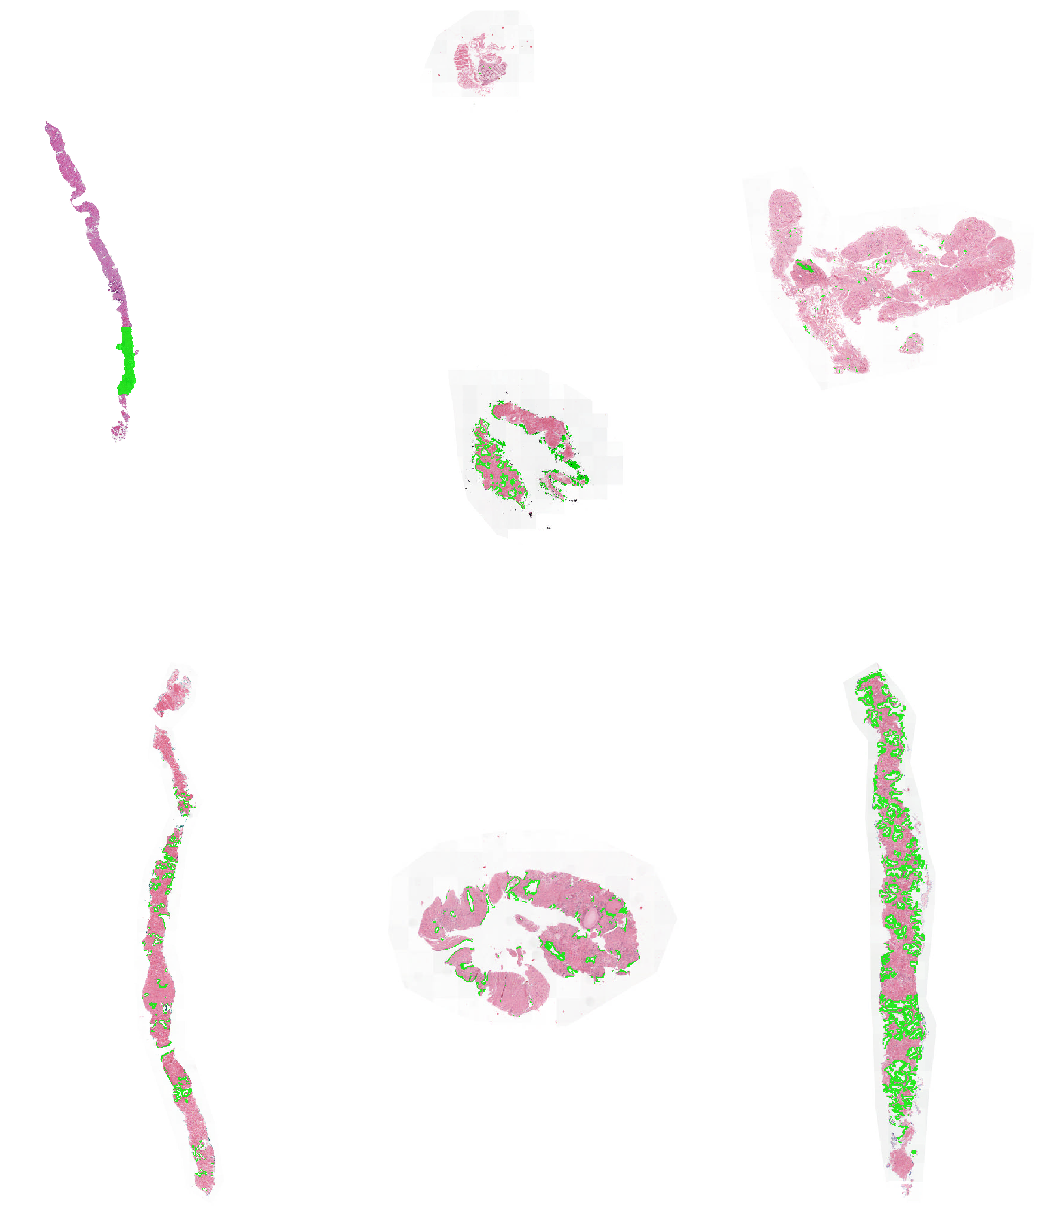

In [34]:
overlay_mask_on_slide(images[:6])